In [28]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pytz
from zoneinfo import ZoneInfo

In [49]:
temp_casc = pd.read_csv('temperature_samples/raw/Cascavel_R3_combined.csv', parse_dates=['Data Hora, GMT-03:00'])
temp_casc = temp_casc.rename(columns={'Data Hora, GMT-03:00': 'Date', 'Temp., °F (LGR S/N: 2254247, SEN S/N: 2254247)': 'temp'})
temp_casc['Date'] = temp_casc['Date'].str.replace('H', ':')
temp_casc['Date'] = temp_casc['Date'].str.replace('min', ':')
temp_casc['Date'] = temp_casc['Date'].str.replace('s', '')
temp_casc['Date'] =pd.to_datetime(temp_casc['Date'] )
temp_casc['temp'] = (temp_casc['temp']-32)*(5/9)

temp_casc.to_csv('temperature_samples/processed/Cascavel_R3_2018_2019_temp_C.csv', index=False)

In [50]:
temp_darro_2018 = pd.read_csv('temperature_samples/raw/Darro_R1_2018_combined_temp_F.csv', parse_dates=['Data Hora, GMT-03:00'])
temp_darro_2018 = temp_darro_2018.rename(columns={'Data Hora, GMT-03:00': 'Date', 'Temp., °F (LGR S/N: 10600576, SEN S/N: 10600576)': 'temp'})
temp_darro_2018['Date'] = temp_darro_2018['Date'].str.replace('H', ':')
temp_darro_2018['Date'] = temp_darro_2018['Date'].str.replace('min', ':')
temp_darro_2018['Date'] = temp_darro_2018['Date'].str.replace('s', '')
temp_darro_2018['Date'] =pd.to_datetime(temp_darro_2018['Date'] )
temp_darro_2018['temp'] = (temp_darro_2018['temp']-32)*(5/9)

temp_darro_2019 = pd.read_csv('temperature_samples/raw/Darro_R1_2019_combined_temp_F.csv', parse_dates=['Data Hora, GMT-04:30'])
temp_darro_2019 = temp_darro_2019.rename(columns={'Data Hora, GMT-04:30': 'Date', 'Temp., °F (LGR S/N: 9906895, SEN S/N: 9906895)': 'temp'})
temp_darro_2019['Date'] = temp_darro_2019['Date'].str.replace('H', ':')
temp_darro_2019['Date'] = temp_darro_2019['Date'].str.replace('min', ':')
temp_darro_2019['Date'] = temp_darro_2019['Date'].str.replace('s', '')
temp_darro_2019['Date'] = pd.to_datetime(temp_darro_2019['Date'] )
gmt_minus_4_30  = pytz.FixedOffset(-270)
gmt_minus_3 = pytz.FixedOffset(-180)
temp_darro_2019['Date'] = temp_darro_2019['Date'].dt.tz_localize(gmt_minus_4_30 )
temp_darro_2019['Date'] = temp_darro_2019['Date'].dt.tz_convert(gmt_minus_3)
temp_darro_2019['Date'] = temp_darro_2019['Date'].dt.tz_localize(None)
temp_darro_2019['temp'] = (temp_darro_2019['temp']-32)*(5/9)

temp_darro = pd.concat([temp_darro_2018, temp_darro_2019])
temp_darro.to_csv('temperature_samples/processed/Darro_R1_2018_2019_temp_C.csv')

In [31]:
def ppm_to_molarity(ppm, gas, T, P=1, Vh=60, Vb=160, temp_input = 'C'):
    # for headspace measurements
    # T in kelvin
    # assuming P = 1 atm
    # MW in g/mole
    
    if temp_input == 'C':
        T = T+273.15
    constants = {'ch4': {'H': 39769, 'MW': 16.04},
                 'o2': {'H': 43414, 'MW': 32},
                 'co2': {'H': 1630, 'MW': 44},
                 'R': 1.98719}
    
    constants['ch4']['H'] = 1/(np.exp((-365.183 + 18106.7 / T + 49.7554 * np.log(T) + -0.00028503 * T) / constants['R']))
    constants['o2']['H'] = 1/(np.exp((-286.942 + 15450.6 / T + 36.5593 * np.log(T) + 0.01876620 * T) / constants['R']))
    
    Cg = (ppm*1e-6)
    pg = Cg * P #partial pressure of gas at atmospheric pressure (atm)
    CAH = 55.5 * (pg/constants[gas]['H']) * constants[gas]['MW'] + ((Vh/(Vb-Vh)) * Cg * (constants[gas]['MW']/22.4) * (273 / T)) #gas concentration in aqueous phase (g/L)

    return (CAH / constants[gas]['MW']) * 1e6 # umol gas / L water

In [45]:
concentration_data = pd.read_csv('temperature_samples/raw/Tanguro_July_2023_Python_Isotopes_withtemps.csv')
concentration_data = concentration_data.loc[concentration_data['Type']=='Water']
concentration_data['CH4_uM'] = ppm_to_molarity(concentration_data['CH4'], 'ch4', concentration_data['Temperature'], P=1, Vh=4, Vb=12, temp_input = 'C')
concentration_data['CO2_uM'] = ppm_to_molarity(concentration_data['CO2'], 'co2', concentration_data['Temperature'], P=1, Vh=4, Vb=12, temp_input = 'C')
concentration_data['O2_uM'] = ppm_to_molarity(concentration_data['DO'], 'o2', concentration_data['Temperature'], P=1, Vh=4, Vb=12, temp_input = 'C')
concentration_data.to_csv('temperature_samples/processed/Tanguro_July_2023_concentrations.csv')

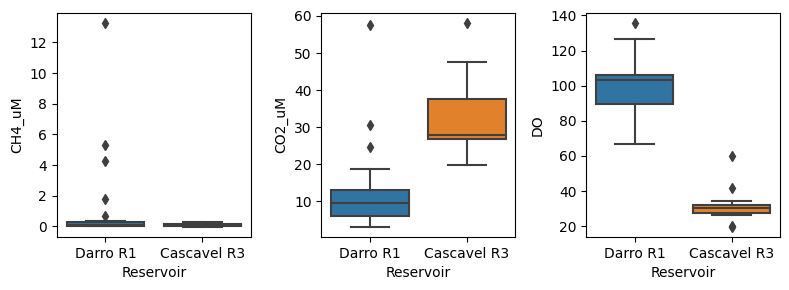

In [33]:
fig, axes=plt.subplots(1,3, figsize=(8,3))
sns.boxplot(data=concentration_data, x='Reservoir', y='CH4_uM', ax=axes[0])
sns.boxplot(data=concentration_data, x='Reservoir', y='CO2_uM', ax=axes[1])
sns.boxplot(data=concentration_data, x='Reservoir', y='DO', ax=axes[2])

fig.tight_layout()

In [ ]:
ch4_diffusive = pd.read_csv('gas_fluxes/B_CH4_diffusive_20250302_LAKE.csv', na_values=['NA'], parse_dates=['datetime_start','datetime_end'])
ch4_ebullitive = pd.read_csv('gas_fluxes/B_CH4_ebullitive_20250302_LAKE.csv', na_values=['NA'], parse_dates=['datetime_start','datetime_end'])
co2_diffusive = pd.read_csv('gas_fluxes/B_CO2_diffusive_20250302_LAKE.csv', na_values=['NA'], parse_dates=['datetime_start','datetime_end'])
co2_ebullitive = pd.read_csv('gas_fluxes/B_CO2_ebullitive_20250302_LAKE.csv', na_values=['NA'], parse_dates=['datetime_start','datetime_end'])

/tmp/ipykernel_1674/2783094627.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  ch4_diffusive = pd.read_csv('gas_fluxes/B_CH4_diffusive_20250302_LAKE.csv', na_values=['NA'], parse_dates=['datetime_start','datetime_end'])


In [40]:
ch4_diffusive.loc[ch4_diffusive['umol_m2_hr']<0, 'umol_m2_hr'] = np.nan

ch4_diffusive['Date'] = ch4_diffusive['datetime_end'].dt.date

ch4_diffusive_daily = ch4_diffusive.groupby(by=['pond', 'chamber', 'Date']).aggregate({
                                                'slope_ppm_hr': 'mean',
                                                'r2': 'mean', 
                                                'air_temp': 'mean', #C
                                                'sur_wat_temp': 'mean', #C
                                                'umol_m2_hr': 'mean', #mm
                                                }).reset_index()

ch4_diffusive_daily['umol_m2_d'] = ch4_diffusive_daily['umol_m2_hr'] * 24
ch4_diffusive_daily['mg_m2_d'] = ch4_diffusive_daily['umol_m2_d']*0.01604

ch4_diffusive_daily_chamber_avg = ch4_diffusive_daily.groupby(by=['pond', 'Date']).aggregate({
                                                'slope_ppm_hr': 'mean',
                                                'r2': 'mean', 
                                                'air_temp': 'mean', #C
                                                'sur_wat_temp': 'mean', #C
                                                'mg_m2_d': 'mean', #mm
                                                }).reset_index()

In [41]:
# calculate daily fluxes for CH4 ebullition
ch4_ebullitive.loc[ch4_ebullitive['umol_m2_hr']<0, 'umol_m2_hr'] = np.nan
ch4_ebullitive['Date'] = ch4_ebullitive['datetime_end'].dt.date

ch4_ebullitive_daily = ch4_ebullitive.groupby(by=['pond', 'chamber', 'Date']).aggregate({ 
                                                'air_temp': 'mean', #C
                                                'sur_wat_temp': 'mean', #C
                                                'umol_m2_hr': 'mean', #mm
                                                }).reset_index()

ch4_ebullitive_daily['umol_m2_d'] = ch4_ebullitive_daily['umol_m2_hr'] * 24
ch4_ebullitive_daily['mg_m2_d'] = ch4_ebullitive_daily['umol_m2_d']*0.01604

In [42]:
# calculate daily fluxes for CO2 diffusion
co2_diffusive.loc[co2_diffusive['umol_m2_hr']<0, 'umol_m2_hr'] = np.nan

co2_diffusive['Date'] = co2_diffusive['datetime_end'].dt.date

co2_diffusive_daily = co2_diffusive.groupby(by=['pond', 'chamber', 'Date']).aggregate({
                                                'slope_ppm_hr': 'mean',
                                                'r2': 'mean', 
                                                'air_temp': 'mean', #C
                                                'sur_wat_temp': 'mean', #C
                                                'umol_m2_hr': 'mean', #mm
                                                }).reset_index()

co2_diffusive_daily['umol_m2_d'] = co2_diffusive_daily['umol_m2_hr'] * 24
co2_diffusive_daily['mg_m2_d'] = co2_diffusive_daily['umol_m2_d']*0.04401

co2_diffusive_daily_chamber_avg = co2_diffusive_daily.groupby(by=['pond', 'Date']).aggregate({
                                                'slope_ppm_hr': 'mean',
                                                'r2': 'mean', 
                                                'air_temp': 'mean', #C
                                                'sur_wat_temp': 'mean', #C
                                                'mg_m2_d': 'mean', #mm
                                                }).reset_index()

In [43]:
# calculate daily fluxes for CO2 ebullition
co2_ebullitive.loc[co2_ebullitive['umol_m2_hr']<0, 'umol_m2_hr'] = np.nan
co2_ebullitive['Date'] = co2_ebullitive['datetime_end'].dt.date

co2_ebullitive_daily = co2_ebullitive.groupby(by=['pond', 'chamber', 'Date']).aggregate({ 
                                                'air_temp': 'mean', #C
                                                'sur_wat_temp': 'mean', #C
                                                'umol_m2_hr': 'mean', #mm
                                                }).reset_index()

co2_ebullitive_daily['umol_m2_d'] = co2_ebullitive_daily['umol_m2_hr'] * 24
co2_ebullitive_daily['mg_m2_d'] = co2_ebullitive_daily['umol_m2_d']*0.04401

In [44]:
df_all_ch4 =pd.merge(ch4_diffusive_daily, ch4_ebullitive_daily, on =['pond', 'chamber', 'Date'], suffixes=['_diff', '_ebul'], how='outer')
df_all_ch4 = df_all_ch4.replace('B', 'burned')
df_all_ch4 = df_all_ch4.replace('U', 'unburned')


df_all_co2 =pd.merge(co2_diffusive_daily, co2_ebullitive_daily, on =['pond', 'chamber', 'Date'], suffixes=['_diff', '_ebul'], how='outer')
df_all_co2 = df_all_co2.replace('B', 'burned')
df_all_co2 = df_all_co2.replace('U', 'unburned')

df_all = pd.merge(df_all_ch4, df_all_co2, on =['pond', 'chamber', 'Date'], suffixes=['_ch4', '_co2'], how='outer')
df_all.to_csv('auto_fluxes_all.csv')